#### Description
This code uses distance to the nearest dam to calculate the targeting ratio between CPIS and Irrigated land. 

$$
\text{Targeting Ratio}_{(r = \text{Productivity level})} = \frac{\# \text{ of CPIS in } r}{\sum^{{countries}} ((\# \text{ of CPIS in country }) \times (\text{\% Irrigated Area in country in } r))}
$$

In [2]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import cKDTree
from tqdm import tqdm
import rasterio
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

# List of ISO3 codes for Northern African countries
northern_african_countries = ['DZA', 'EGY', 'LBY', 'MAR', 'SDN', 'TUN', 'ESH', 'MRT']

#### Prep the groundwater productivity data

In [3]:
# Load the groundwater productivity data
df_GW = pd.read_csv(resolve_path(config['Groundwater_Productivity_path']), sep=r'\s+')

# Create geometry for groundwater productivity points
geometry = [Point(xy) for xy in tqdm(zip(df_GW['X'], df_GW['Y']), desc="Creating geometries")]
gdf_GW = gpd.GeoDataFrame(df_GW, geometry=geometry)
gdf_GW.set_crs(epsg=4326, inplace=True)
gdf_GW.to_file(resolve_path(config['Groundwater_Prod_gpkg_path']))
gdf_GW = gdf_GW.to_crs(epsg=3857)


# Map groundwater productivity to categories
value_map_cat = {'VH': 20.0, 'H': 12.5, 'M': 3.0, 'LM': 0.75, 'L': 0.3, 'VL': 0.1}

reverse_map_cat = {v: k for k, v in value_map_cat.items()}

gdf_GW['GW_prod_cat_L_s'] = gdf_GW['GWPROD_V2'].map(value_map_cat)


Creating geometries: 1019265it [00:07, 138781.52it/s]


In [4]:
gdf_GW = gpd.read_file(resolve_path(config['Groundwater_Prod_gpkg_path']))
gdf_GW = gdf_GW.to_crs(epsg=3857)

gdf_GW['GW_prod_cat'] = gdf_GW['Liters_Second'].map(reverse_map_cat)

print(gdf_GW.head())


         X          Y  Liters_Second                         geometry  \
0  9.41405  37.251192            3.0  POINT (1047967.285 4474177.758)   
1  9.46405  37.251192            3.0  POINT (1053533.259 4474177.758)   
2  9.51405  37.251192            3.0  POINT (1059099.234 4474177.758)   
3  9.56405  37.251192            3.0  POINT (1064665.209 4474177.758)   
4  9.61405  37.251192           12.5  POINT (1070231.183 4474177.758)   

  GW_prod_cat  
0           M  
1           M  
2           M  
3           M  
4           H  


Assign each Irrgated Pixel a GW Value and Produce Clean Dataset

In [5]:

# Load the AEI data by country
AEI_by_country = gpd.read_file(resolve_path(config['AEI_2015_All_shp_path']))
AEI_by_country = AEI_by_country.to_crs(gdf_GW.crs)

print("AEI_by_country:")
print(AEI_by_country.head())

# Perform a spatial join to combine AEI with groundwater productivity
gdf_combined = gpd.sjoin(gdf_GW, AEI_by_country, how="left", predicate="within")

print("gdf_combined:")
print(gdf_combined.head())

# Clean combined data
gdf_combined = gdf_combined.rename(columns={'GWPROD_V2': 'GW_prod_cat'})
gdf_combined = gdf_combined.drop(columns=['index_right']).reset_index(drop=True)

print("gdf_combined:")
print(gdf_combined.head())

# Group by country and groundwater productivity category to calculate total AEI
AEI_by_country_and_prod = gdf_combined.groupby(['ISO3', 'GW_prod_cat'])['raster_val'].sum().reset_index()

print('AEI_by_country_and_prod:')
print(AEI_by_country_and_prod.head())

# Calculate total AEI per country
total_AEI_per_country = gdf_combined.groupby('ISO3')['raster_val'].sum().reset_index()
total_AEI_per_country = total_AEI_per_country.rename(columns={'raster_val': 'Total_AEI'})

print('total_AEI_per_country')
print(total_AEI_per_country.head())

# Merge the AEI per category with the total AEI per country
merged_with_AEI = AEI_by_country_and_prod.merge(total_AEI_per_country, on='ISO3')

# Calculate the percentage of AEI per groundwater productivity category within each country
merged_with_AEI['Percent_AEI'] = (merged_with_AEI['raster_val'] / merged_with_AEI['Total_AEI'])

# Restrict to SSA
merged = merged_with_AEI[~merged_with_AEI['ISO3'].isin(northern_african_countries)]

print('merged_with_AEI:')
print(merged.head())

AEI_by_country:
    raster_val ISO3                                           geometry
0   388.435089  TUN  POLYGON ((1038981.914 4462363.503, 1029705.290...
1   207.121201  TUN  POLYGON ((1057535.163 4474011.088, 1057535.163...
2   721.080872  TUN  POLYGON ((1066811.787 4474011.088, 1066811.787...
3   962.729492  TUN  POLYGON ((1076088.411 4474011.088, 1076088.411...
4  2777.154541  TUN  POLYGON ((1103918.284 4474011.088, 1113194.908...
gdf_combined:
         X          Y  Liters_Second                         geometry  \
0  9.41405  37.251192            3.0  POINT (1047967.285 4474177.758)   
0  9.41405  37.251192            3.0  POINT (1047967.285 4474177.758)   
0  9.41405  37.251192            3.0  POINT (1047967.285 4474177.758)   
0  9.41405  37.251192            3.0  POINT (1047967.285 4474177.758)   
0  9.41405  37.251192            3.0  POINT (1047967.285 4474177.758)   

  GW_prod_cat  index_right  raster_val ISO3  
0           M      16879.0         0.0  ZAF  
0           M

In [6]:
print(merged.count())

ISO3           216
GW_prod_cat    216
raster_val     216
Total_AEI      216
Percent_AEI    192
dtype: int64


In [7]:
print(AEI_by_country.head())
print(gdf_GW.head())

    raster_val ISO3                                           geometry
0   388.435089  TUN  POLYGON ((1038981.914 4462363.503, 1029705.290...
1   207.121201  TUN  POLYGON ((1057535.163 4474011.088, 1057535.163...
2   721.080872  TUN  POLYGON ((1066811.787 4474011.088, 1066811.787...
3   962.729492  TUN  POLYGON ((1076088.411 4474011.088, 1076088.411...
4  2777.154541  TUN  POLYGON ((1103918.284 4474011.088, 1113194.908...
         X          Y  Liters_Second                         geometry  \
0  9.41405  37.251192            3.0  POINT (1047967.285 4474177.758)   
1  9.46405  37.251192            3.0  POINT (1053533.259 4474177.758)   
2  9.51405  37.251192            3.0  POINT (1059099.234 4474177.758)   
3  9.56405  37.251192            3.0  POINT (1064665.209 4474177.758)   
4  9.61405  37.251192           12.5  POINT (1070231.183 4474177.758)   

  GW_prod_cat  
0           M  
1           M  
2           M  
3           M  
4           H  


Assign groundwater values to each center pivot and count number per level

In [8]:
# Load the CPIS shapefile
gdf_CPIS = gpd.read_file(resolve_path(config['Combined_CPIS_All_shp_path']))
gdf_CPIS = gdf_CPIS.to_crs(gdf_GW.crs)

# Calculate centroids of the CPIS polygons
gdf_CPIS['centroid'] = gdf_CPIS.geometry.centroid

# Convert centroids to coordinates for KDTree
cp_centroids_coords = np.array(list(gdf_CPIS['centroid'].apply(lambda geom: (geom.x, geom.y))))

# Extract coordinates of groundwater points
gw_coords = np.array(list(gdf_GW.geometry.apply(lambda geom: (geom.x, geom.y))))

# Build a KDTree for the groundwater points
tree = cKDTree(gw_coords)

# Query the nearest groundwater point for each CPIS centroid
_, idx = tree.query(cp_centroids_coords, k=1)

# Assign the nearest groundwater productivity value to each CPIS
gdf_CPIS['GW_prod_cat'] = gdf_GW.iloc[idx]['GW_prod_cat'].values

# Remove the centroid column afterwards
gdf_CPIS = gdf_CPIS.drop(columns=['centroid'])

# Check
print(gdf_CPIS[['ISO3', 'GW_prod_cat', 'geometry']].head())

# Restrict to SSA
gdf_CPIS_SSA = gdf_CPIS[~gdf_CPIS['ISO3'].isin(northern_african_countries)]
print(f'gdf_CPIS_SSA: {gdf_CPIS_SSA.head()}')

# Group by groundwater productivity category to calculate the total number of CPIS (per level overall and by country)
CPIS_SSA_per_country_level = gdf_CPIS_SSA.groupby(['ISO3', 'GW_prod_cat']).size().reset_index(name='CPIS_per_country_level')
print(f'CPIS_SSA_per_country_level: {CPIS_SSA_per_country_level.head()}')

CPIS_SSA_per_level = gdf_CPIS_SSA.groupby('GW_prod_cat').size().reset_index(name='CPIS_count')
print(f'CPIS_SSA_per_level: {CPIS_SSA_per_level.head()}')

  ISO3 GW_prod_cat                                           geometry
0  ZAF           L  POLYGON ((2158598.021 -4057555.506, 2158658.42...
1  ZAF           L  POLYGON ((2158740.433 -4056950.848, 2158788.75...
2  ZAF           L  POLYGON ((2286656.768 -4053677.724, 2286693.00...
3  ZAF           L  POLYGON ((2285644.300 -4053175.531, 2285704.69...
4  ZAF           L  POLYGON ((2184297.066 -4052314.792, 2184333.29...
gdf_CPIS_SSA:   ISO3                                           geometry GW_prod_cat
0  ZAF  POLYGON ((2158598.021 -4057555.506, 2158658.42...           L
1  ZAF  POLYGON ((2158740.433 -4056950.848, 2158788.75...           L
2  ZAF  POLYGON ((2286656.768 -4053677.724, 2286693.00...           L
3  ZAF  POLYGON ((2285644.300 -4053175.531, 2285704.69...           L
4  ZAF  POLYGON ((2184297.066 -4052314.792, 2184333.29...           L
CPIS_SSA_per_country_level:   ISO3 GW_prod_cat  CPIS_per_country_level
0  AGO           H                      21
1  AGO           L              

In [18]:
# Group by 'ISO3' and count the number of points in each country
points_per_country = gdf_CPIS.groupby('ISO3').size().reset_index(name='Point_Count')

# Inspect the resulting DataFrame
print(points_per_country)

   ISO3  Point_Count
0   AGO           34
1   BFA           35
2   BWA          193
3   DZA          802
4   EGY          290
5   GHA            3
6   GMB            8
7   KEN           65
8   LBY         1519
9   LSO           19
10  MAR          150
11  MDG           36
12  MLI           27
13  MOZ           84
14  MRT           14
15  MWI           53
16  NAM          498
17  NGA            1
18  SEN           75
19  SWZ          162
20  TCD           36
21  TUN            4
22  ZAF        25235
23  ZMB         1191
24  ZWE         1853


In [12]:
# Perform the merge on 'ISO3' and 'GW_prod_cat'
merged_with_cpis = merged_with_AEI.merge(CPIS_SSA_per_country_level, 
                                on=['ISO3', 'GW_prod_cat'], 
                                how='left')

# Print the number of NaN values
print(f'Number of NaN values in CPIS_per_country_level before replacement: {merged_with_cpis['CPIS_per_country_level'].isna().sum()}')

# Replace NaN values in the 'CPIS_count_per_country_level' column with 0
merged_with_cpis['CPIS_per_country_level'] = merged_with_cpis['CPIS_per_country_level'].fillna(0)

# Convert the column to an integer type if needed
merged_with_cpis['CPIS_per_country_level'] = merged_with_cpis['CPIS_per_country_level'].astype(int)

# Add back the corresponding category values
merged_with_cpis['GW_prod_cat_L_s'] = merged_with_cpis['GW_prod_cat'].map(value_map_cat)


print(f'Merged w cpis head: {merged_with_cpis.head()}')
#print(f'Merged: {merged_with_AEI.head()}')
print(f'Merged w cpis tail: {merged_with_cpis.tail()}')
print(merged_with_cpis['ISO3'].unique())


Number of NaN values in CPIS_per_country_level before replacement: 209
Merged w cpis head:   ISO3 GW_prod_cat    raster_val      Total_AEI  Percent_AEI  \
0  AGO           H  55144.969337  168115.312119     0.328019   
1  AGO           L   2917.207626  168115.312119     0.017352   
2  AGO          LM  16349.098923  168115.312119     0.097249   
3  AGO           M  93704.036232  168115.312119     0.557380   
4  AGO          VH      0.000000  168115.312119     0.000000   

   CPIS_per_country_level  GW_prod_cat_L_s  
0                      21            12.50  
1                       2             0.30  
2                       3             0.75  
3                       8             3.00  
4                       0            20.00  
Merged w cpis tail:     ISO3 GW_prod_cat     raster_val      Total_AEI  Percent_AEI  \
253  ZWE           L  251910.184516  478508.667487     0.526449   
254  ZWE          LM   90636.649854  478508.667487     0.189415   
255  ZWE           M   92136.5487

In [32]:
# Define bootstrapping function
def bootstrap_targeting_ratio(numerator, denominator, num_bootstrap=1000):
    """
    Perform bootstrapping to estimate confidence intervals for the targeting ratio.
    """
    ratios = []
    numerators = []
    denominators = []
    for _ in range(num_bootstrap):
        # Resample numerators and denominators using Poisson distribution
        boot_numerator = np.random.poisson(numerator)
        boot_denominator = np.random.poisson(denominator)

        # Store values for separate plotting
        numerators.append(boot_numerator)
        denominators.append(boot_denominator)

        # Calculate the ratio if the denominator is not zero
        if boot_denominator != 0:
            boot_ratio = boot_numerator / boot_denominator
        else:
            boot_ratio = np.nan
        
        ratios.append(boot_ratio)
    
    # Convert to numpy arrays for easier percentile calculation
    ratios = np.array(ratios)
    numerators = np.array(numerators)
    denominators = np.array(denominators)
    
    # Return the 2.5th and 97.5th percentiles as the confidence interval
    return np.nanpercentile(ratios, 2.5), np.nanpercentile(ratios, 97.5), numerators, denominators

# Final Calculation of Targeting Ratio with Bootstrapping
targeting_ratios = []

for prod_level in CPIS_SSA_per_level['GW_prod_cat']:
    # Total CPIS count for this productivity level
    CPIS_count = CPIS_SSA_per_level[CPIS_SSA_per_level['GW_prod_cat'] == prod_level]['CPIS_count'].values[0]
    print(f'CPIS count for {prod_level}: {CPIS_count}')

    # Filter data for this productivity level
    country_data = merged_with_cpis[merged_with_cpis['GW_prod_cat'] == prod_level]
    
    # Calculate the denominator: sum over countries [(CPIS count in country) * (Percent_AEI)]
    denominator = 0
    for country in points_per_country['ISO3']:
        try:
            # Get CPIS count per level per country
            country_cpis_count = points_per_country.loc[points_per_country['ISO3'] == country, 'Point_Count'].values[0]
            
            # Get Percent_AEI for this country and productivity level
            percent_aei = merged_with_cpis[
                (merged_with_cpis['ISO3'] == country) & 
                (merged_with_cpis['GW_prod_cat'] == prod_level)
            ]['Percent_AEI'].values[0]

            # Skip if either value is nan
            if np.isnan(country_cpis_count) or np.isnan(percent_aei):
                continue

            # Add to the denominator
            denominator += country_cpis_count * percent_aei

        except KeyError:
            continue
        
    print(f'Denominator for {prod_level}: {denominator}')

    # Calculate the targeting ratio
    if denominator == 0:
        targeting_ratio = np.nan  # Handle zero denominator
        ci_lower, ci_upper = np.nan, np.nan
        boot_numerators, boot_denominators = np.array([]), np.array([])
    else:
        targeting_ratio = CPIS_count / denominator
        # Bootstrapping to estimate confidence intervals
        ci_lower, ci_upper, boot_numerators, boot_denominators = bootstrap_targeting_ratio(CPIS_count, denominator)

    # Store the numerator and denominator values for plotting
    targeting_ratios.append({
        'GW_prod_cat_L_s': prod_level,
        'Numerator': CPIS_count,
        'Denominator': denominator,
        'Targeting_Ratio': targeting_ratio,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper
    })

# Convert targeting ratios to DataFrame for easy viewing
df_targeting_ratios = pd.DataFrame(targeting_ratios)

# Display the resulting targeting ratios with confidence intervals
print(df_targeting_ratios)

CPIS count for H: 1546
Denominator for H: 3139.963535835823
CPIS count for L: 8051
Denominator for L: 9229.002236087787
CPIS count for LM: 14362
Denominator for LM: 14741.214326747298
CPIS count for M: 5016
Denominator for M: 4307.304523168639
CPIS count for VH: 368
Denominator for VH: 627.925120575327
CPIS count for VL: 152
Denominator for VL: 278.7250692153565
  GW_prod_cat_L_s  Numerator   Denominator  Targeting_Ratio  CI_Lower  \
0               H       1546   3139.963536         0.492362  0.465601   
1               L       8051   9229.002236         0.872359  0.847188   
2              LM      14362  14741.214327         0.974275  0.953932   
3               M       5016   4307.304523         1.164533  1.120786   
4              VH        368    627.925121         0.586057  0.513339   
5              VL        152    278.725069         0.545340  0.446209   

   CI_Upper  
0  0.520487  
1  0.900564  
2  0.996960  
3  1.213385  
4  0.663314  
5  0.665414  


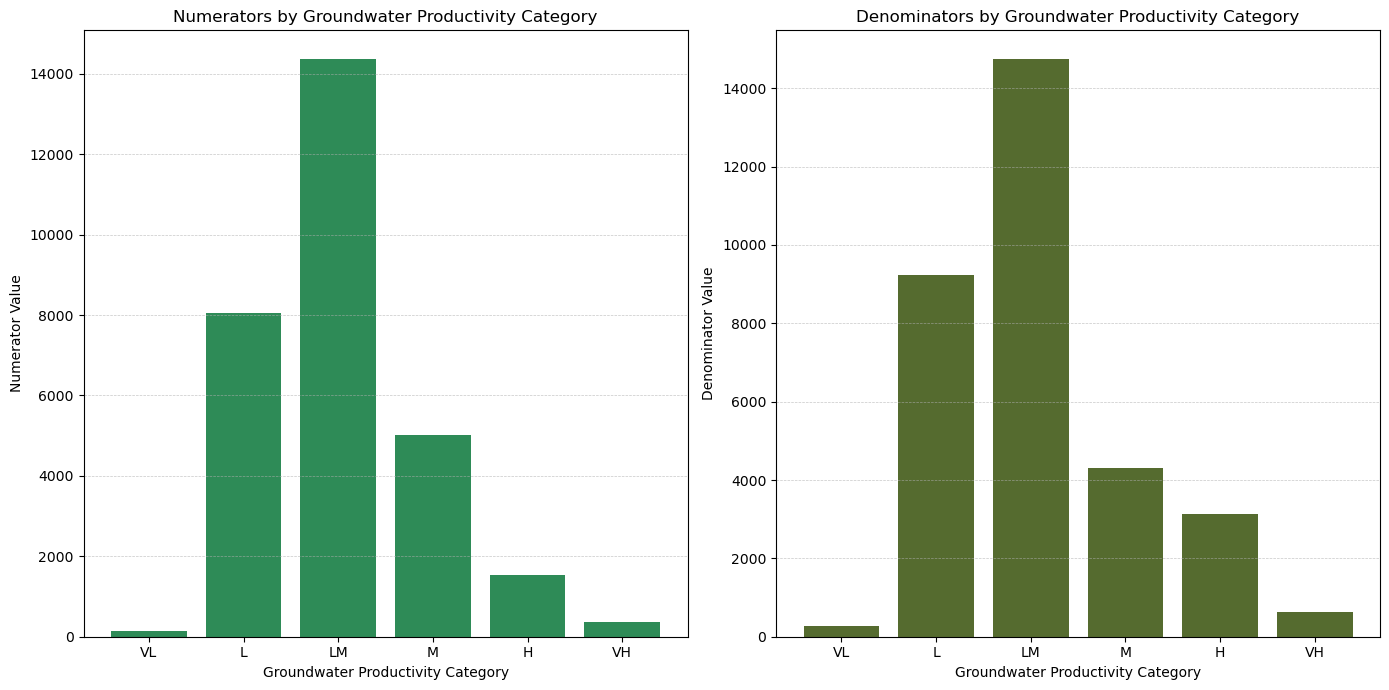

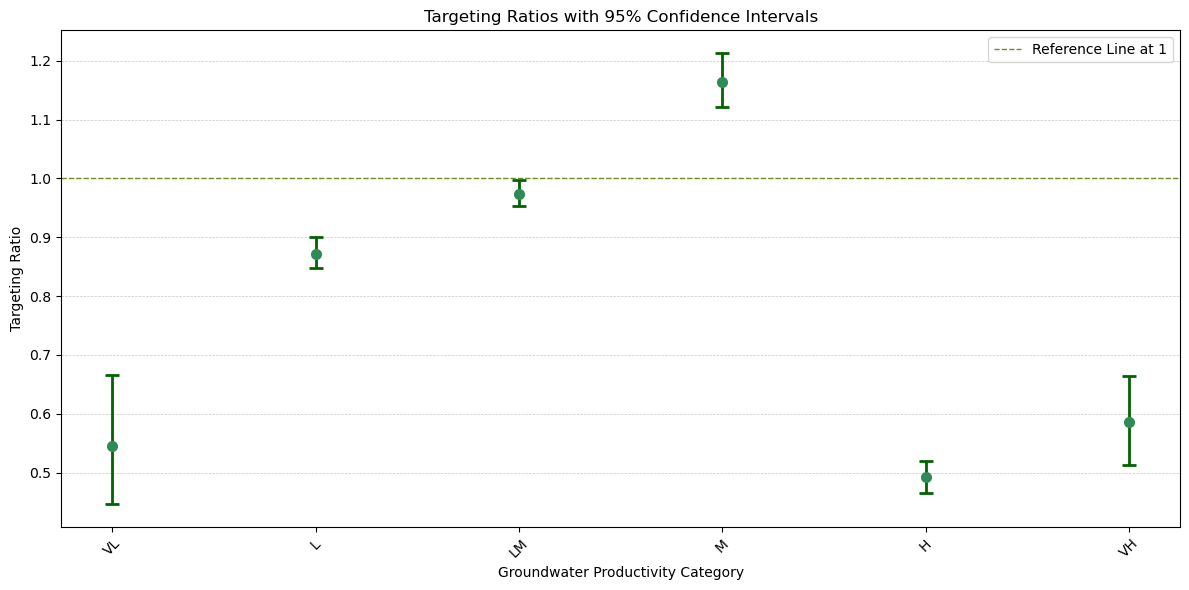

In [34]:
# Plotting Numerators and Denominators Separately
plt.figure(figsize=(14, 7))

# Plot Numerators
plt.subplot(1, 2, 1)
plt.bar(df_targeting_ratios['GW_prod_cat_L_s'], df_targeting_ratios['Numerator'], color='seagreen')
plt.title('Numerators by Groundwater Productivity Category')
plt.xlabel('Groundwater Productivity Category')
plt.ylabel('Numerator Value')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Plot Denominators
plt.subplot(1, 2, 2)
plt.bar(df_targeting_ratios['GW_prod_cat_L_s'], df_targeting_ratios['Denominator'], color='darkolivegreen')
plt.title('Denominators by Groundwater Productivity Category')
plt.xlabel('Groundwater Productivity Category')
plt.ylabel('Denominator Value')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Plotting Targeting Ratios with Confidence Intervals
plt.figure(figsize=(12, 6))
ratios = df_targeting_ratios['Targeting_Ratio']
lower_errors = ratios - df_targeting_ratios['CI_Lower']
upper_errors = df_targeting_ratios['CI_Upper'] - ratios
plt.errorbar(df_targeting_ratios['GW_prod_cat_L_s'], ratios, yerr=[lower_errors, upper_errors],
             fmt='o', ecolor='darkgreen', capsize=5, elinewidth=2, markeredgewidth=2, color='seagreen')
plt.axhline(y=1, color='olivedrab', linestyle='--', linewidth=1, label='Reference Line at 1')
plt.xlabel('Groundwater Productivity Category')
plt.ylabel('Targeting Ratio')
plt.title('Targeting Ratios with 95% Confidence Intervals')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

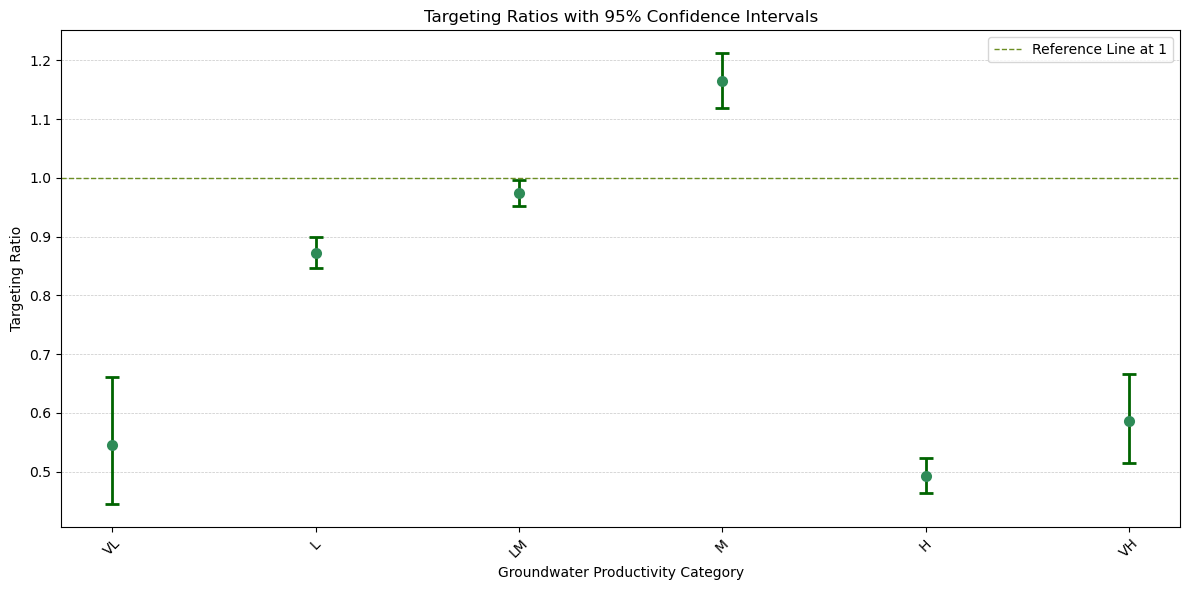

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the correct order of the groundwater productivity categories
desired_order = ['VL', 'L', 'LM', 'M', 'H', 'VH']

# Reorder the DataFrame based on the desired order
df_targeting_ratios['GW_prod_cat_L_s'] = pd.Categorical(df_targeting_ratios['GW_prod_cat_L_s'], categories=desired_order, ordered=True)
df_targeting_ratios = df_targeting_ratios.sort_values('GW_prod_cat_L_s')

# Extract data for plotting
prod_levels = df_targeting_ratios['GW_prod_cat_L_s']
ratios = df_targeting_ratios['Targeting_Ratio']
ci_lower = df_targeting_ratios['CI_Lower']
ci_upper = df_targeting_ratios['CI_Upper']

# Calculate error bars (difference between ratios and confidence bounds)
lower_errors = ratios - ci_lower
upper_errors = ci_upper - ratios

# Plotting the targeting ratios with error bars
plt.figure(figsize=(12, 6))

# Error bar plot
plt.errorbar(prod_levels, ratios, yerr=[lower_errors, upper_errors], fmt='o', 
             ecolor='darkgreen', capsize=5, elinewidth=2, markeredgewidth=2, color='seagreen')

# Adding labels and title
plt.axhline(y=1, color='olivedrab', linestyle='--', linewidth=1, label='Reference Line at 1')
plt.xlabel('Groundwater Productivity Category')
plt.ylabel('Targeting Ratio')
plt.title('Targeting Ratios with 95% Confidence Intervals')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.legend()

# Show the plot
plt.show()
